In this notebook i'll use the sklearn pipeline for the ML project development.

The data i'm using was cleaned using this notebook : https://github.com/RaphaelRoriz/Machine_learning/blob/master/housesPricesDataset/House%20Prices%20regressions.ipynb


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor as xgbr
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

%matplotlib inline

# Functions

In [2]:
def scores_train(model,model_predictions_train):
    print('Scores on training data:')
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, model_predictions_train)))
    print('R2 score:', model.score(X_train,y_train))

In [3]:
def scores_test(model,model_predictions_test):
    print('Scores on test data:')
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, model_predictions_test)))
    print('R2 score:', model.score(X_test,y_test))

In [4]:
def plot_train_test_predictions(model_name,model_predictions_train,model_predictions_test):
    
    plt.scatter(model_predictions_train, y_train, c = "blue",  label = "Training data")
    plt.scatter(model_predictions_test, y_test, c = "black",  label = "Test data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

In [5]:
def plot_y_predictions(model_name,model_predictions_train,model_predictions_test):
    #plot the predictions vs the actual value for train and test data
    
    #train data
    train_fig = plt.figure()
    plt.plot(y_train,c= 'green',label = 'Y train',marker = 'o',linestyle = 'None')
    plt.plot(model_predictions_train,c= 'red',label = 'Train predictions',marker = 'o',linestyle = 'None')
    plt.title(model_name+'(Train)')
    plt.ylabel('SalePrice')
    plt.legend(loc = "upper right")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    train_fig.show()
    
    #test data
    test_fig = plt.figure()
    plt.plot(y_test,c= 'green',label = 'Y test',marker = 'o',linestyle = 'None')
    plt.plot(model_predictions_test,c= 'red',label = 'Test predictions',marker = 'o',linestyle = 'None')
    plt.title(model_name + '(test)')
    plt.ylabel('SalePrice')
    plt.legend(loc = "upper right")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    test_fig.show()

In [6]:
 def kaggle_submission_csv(model_name,model):
    predictions = model.predict(houses_test)
    predictions = pd.Series(predictions)
    entry = pd.concat([test_ids,predictions],axis=1)
    entry.columns = ['Id','SalePrice']
    entry.to_csv(model_name+'_entry.csv',index=False)

# Importing data

In [7]:
houses_train = pd.read_pickle('houses_train_cleaned.pkl')
houses_test = pd.read_pickle('houses_test_cleaned.pkl')
houses_train.drop('Id',axis =1,inplace =True )

In [8]:
test_ids = houses_test['Id'] #ids for the submission file

# Feature selection

I'll select the features based on the correlation with the target 

In [9]:
houses_train_corr = houses_train.corr()

In [10]:
salePrice_corr = houses_train_corr['SalePrice']

In [11]:
relevant_salePrice_corr = []

#here well searching for relevation correlations , ill consider a correlation relevant if its >= 0.5 and <= -0.5
for (columnName, columnData) in houses_train_corr['SalePrice'].iteritems():
    if columnData >= 0.5 or columnData <= -0.5: #0.5 is the corr that i got the best results
        relevant_salePrice_corr.append((columnName,columnData))

In [12]:
relevant_salePrice_corr

[('OverallQual', 0.7909816005838047),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113867),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('GrLivArea', 0.7086244776126511),
 ('FullBath', 0.5606637627484452),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('SalePrice', 1.0),
 ('TotalConstructedSF', 0.809741322904717),
 ('TotalBath', 0.6317310679319897),
 ('ExterQual_TA', -0.589043523409763),
 ('KitchenQual_TA', -0.5192978536548846)]

In [13]:
#We'll not use the GarageArea column because it may be too much correlated to GarageCars
houses_train_corr['GarageArea']['GarageCars']

0.8824754142814603

In [14]:
relevant_columns_names_train = []
for i in relevant_salePrice_corr:
    relevant_columns_names_train.append(i[0])

In [15]:
relevant_columns_names_train.remove('GarageArea')

In [16]:
relevant_columns_names_train

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'SalePrice',
 'TotalConstructedSF',
 'TotalBath',
 'ExterQual_TA',
 'KitchenQual_TA']

In [17]:
houses_train  = houses_train[relevant_columns_names_train]

In [18]:
#houses_train

In [19]:
#houses_test

# Test dataset for Kaggle submissions

In [20]:
relevant_columns_names_test = relevant_columns_names_train.remove('SalePrice')
houses_test = houses_test[relevant_columns_names_train]

# Train and test sets split

In [21]:
y = houses_train['SalePrice']
X = houses_train.drop(['SalePrice'],axis = 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## KFold

In [23]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

# Evaluating models

## Create models

## 1)Linear regression

In [24]:
linearRegressionPipeline = Pipeline(steps=[
    ('model',LinearRegression())
]
)

## 2)Linear regression with StandardScaler and PolynomialFeatures

In [25]:
linearRegressionPipeline2 = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('poly',PolynomialFeatures(degree = 2)),
    ('model',LinearRegression())
]
)

## 3)Ridge Regression

In [26]:
RidgeRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('poly',PolynomialFeatures(degree = 2)),
    ('model',Ridge())
]
)

## 4)Lasso Regression

In [27]:
LassoRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',Lasso())
]
)

## 5)Support Vector Regression

In [28]:
SVRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',SVR())
]
)

## 6)Random Forest Regression

In [29]:
RFRegressionPipeline = Pipeline(steps=[
    ('model',RandomForestRegressor())
]
)

## 7)XGBoost Regression

In [30]:
XGBRegressionPipeline = Pipeline(steps=[
    ('model',xgbr())
]
)

## Evaluate

In [31]:
models = [
    ('logReg' , linearRegressionPipeline),
    ('logRegScaled',linearRegressionPipeline2),
    ('ridgeReg',RidgeRegressionPipeline),
    ('LassoReg',LassoRegressionPipeline),
    ('SVReg',SVRegressionPipeline),
    ('RFReg',RFRegressionPipeline),
    ('XGBReg',XGBRegressionPipeline)
]

In [32]:
results = {}
names = []
scoring = 'neg_mean_squared_error'

In [33]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

In [34]:
for name,model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results[name] = cv_results
        
    

logReg
logRegScaled
ridgeReg
LassoReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.p

SVReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/dat

RFReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGBReg


In [35]:
results

{'logReg': array([-9.03903402e+08, -1.91855418e+09, -1.76599587e+09, -1.18354653e+09,
        -1.58089609e+09]),
 'logRegScaled': array([-6.87161481e+08, -1.35349522e+09, -1.83141782e+09, -8.87697865e+08,
        -1.04104703e+09]),
 'ridgeReg': array([-6.75711309e+08, -1.33239335e+09, -1.81294312e+09, -8.69248717e+08,
        -1.02312077e+09]),
 'LassoReg': array([-9.03910974e+08, -1.91850258e+09, -1.76599625e+09, -1.18353129e+09,
        -1.58089657e+09]),
 'SVReg': array([-5.71021232e+09, -4.59533039e+09, -7.49575601e+09, -7.44181163e+09,
        -7.82495419e+09]),
 'RFReg': array([-7.43233100e+08, -8.10572913e+08, -1.45402625e+09, -7.48993047e+08,
        -9.19071578e+08]),
 'XGBReg': array([-8.50607671e+08, -5.98030997e+08, -1.40608779e+09, -6.71311065e+08,
        -7.95383519e+08])}

In [36]:
RMSE_average_results = {}
for key in results.keys():
    RMSE_average_results[key] = np.sqrt(results[key] * -1).sum()/5

In [37]:
RMSE_average_results

{'logReg': 38010.64770262848,
 'logRegScaled': 33571.64627995564,
 'ridgeReg': 33308.87289979314,
 'LassoReg': 38010.51289122882,
 'SVReg': 80931.51079448091,
 'RFReg': 30309.698160101154,
 'XGBReg': 29045.980866128306}

In [38]:
best_score = ('model',float('inf'))
for key in RMSE_average_results.keys():
    if(RMSE_average_results[key] < best_score[1]):
        best_score = (key,RMSE_average_results[key])

In [39]:
best_score

('XGBReg', 29045.980866128306)

# Best Model = XGBoost

## Comparing train and test scores

In [40]:
XGBRegressionPipeline.fit(X_train,y_train)
train_predictions = XGBRegressionPipeline.predict(X_train)
test_predictions = XGBRegressionPipeline.predict(X_test)

In [41]:
scores_train(XGBRegressionPipeline,train_predictions)

Scores on training data:
RMSE: 2543.560434108653
R2 score: 0.9989748850931641


In [42]:
scores_test(XGBRegressionPipeline,test_predictions)

Scores on test data:
RMSE: 26446.29382345661
R2 score: 0.8888566583336857


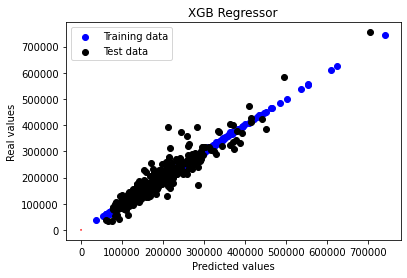

In [43]:
plot_train_test_predictions('XGB Regressor',train_predictions,test_predictions)

/home/raphael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':
/home/raphael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


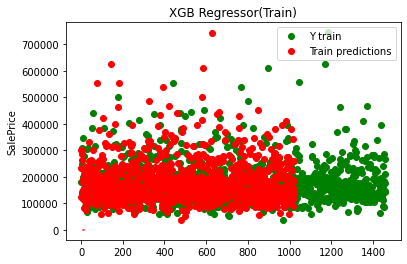

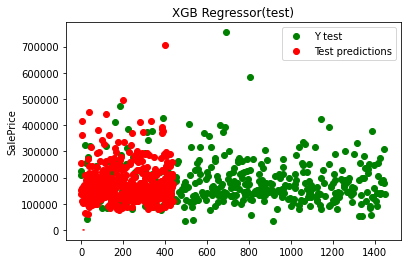

In [44]:
plot_y_predictions('XGB Regressor',train_predictions,test_predictions)

## Hyperparamenter Tuning using GridSearchCV

In [45]:
XGBRegressionPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'model', 'model__objective', 'model__base_score', 'model__booster', 'model__colsample_bylevel', 'model__colsample_bynode', 'model__colsample_bytree', 'model__gamma', 'model__gpu_id', 'model__importance_type', 'model__interaction_constraints', 'model__learning_rate', 'model__max_delta_step', 'model__max_depth', 'model__min_child_weight', 'model__missing', 'model__monotone_constraints', 'model__n_estimators', 'model__n_jobs', 'model__num_parallel_tree', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__scale_pos_weight', 'model__subsample', 'model__tree_method', 'model__validate_parameters', 'model__verbosity'])

In [46]:
hyperparameters ={
    "model__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "model__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "model__min_child_weight" : [ 1, 3, 5, 7 ],
     "model__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "model__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
}

In [47]:
grid_search = GridSearchCV(
    estimator=XGBRegressionPipeline,
    param_grid = hyperparameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 2,
    cv = 5)

In [48]:
grid_search.fit(X_train,y_train)

/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=...cale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'model__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'model__max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'model__min_child_weight': [1, 3, 5, 7], 'model__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'model__colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=3, m...cale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None))])

In [50]:
grid_search.best_params_

{'model__colsample_bytree': 0.3,
 'model__gamma': 0.0,
 'model__learning_rate': 0.2,
 'model__max_depth': 6,
 'model__min_child_weight': 3}

In [51]:
train_predictions_gridSearch = grid_search.predict(X_train)
test_predictions_gridSearch = grid_search.predict(X_test)

In [52]:
scores_train(XGBRegressionPipeline,train_predictions)

Scores on training data:
RMSE: 2543.560434108653
R2 score: 0.9989748850931641


In [53]:
scores_test(XGBRegressionPipeline,test_predictions)

Scores on test data:
RMSE: 26446.29382345661
R2 score: 0.8888566583336857


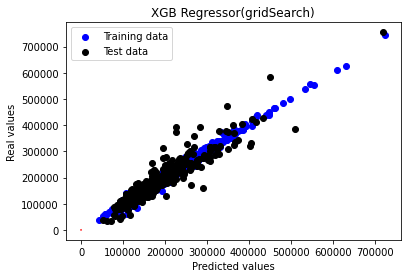

In [54]:
plot_train_test_predictions('XGB Regressor(gridSearch)',train_predictions_gridSearch,test_predictions_gridSearch)

/home/raphael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':
/home/raphael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


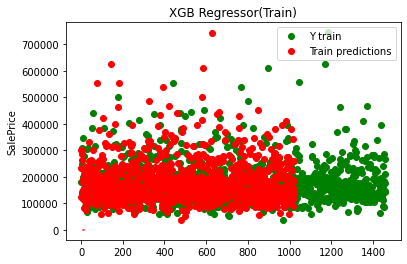

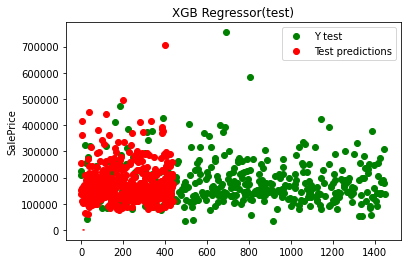

In [55]:
plot_y_predictions('XGB Regressor',train_predictions,test_predictions)

In [56]:
#submission file for kaggle competition
kaggle_submission_csv('xgboost_gridSearch',grid_search)

## Saving trained model for later use

In [60]:
filename = 'XGBR_trained_model.sav'
pickle.dump(model,open(filename,'wb'))

## Loading trained model

In [61]:
trained_model = pickle.load(open(filename,'rb'))

In [62]:
trained_model.score(X_test,y_test)

0.8888566583336857